## 練習時間
將你的結果存成 csv, 上傳你的第一份 Kaggle 成績

Hints: https://stackoverflow.com/questions/16923281/pandas-writing-dataframe-to-csv-file

# [作業目標]
- 檢視並重新執行腳本, 試著將執行結果存檔並提交到 Kaggle 上

# [作業重點]
- 執行後, 將所得結果, 存成可以提交的 csv 檔 (In[10]) (Hint : 使用 pandas.DataFreame.to_csv)

# [提醒]
- 執行後, 將所得結果, 存成可以提交的 csv 檔 (In[10]) (Hint : 使用 pandas.DataFreame.to_csv)

In [1]:
# 載入需要的套件
import os
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\user\AppData\Local\Temp\ipykernel_42936\217467047.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 仿造之前做過的處理

In [2]:
# 設定 data_path
dir_data = './data/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

# 讀取檔案
app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

In [3]:
# 種類 2 種以下的類別型欄位轉標籤編碼 (Label Encoding)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # 紀錄有多少個 columns 被標籤編碼過
            le_count += 1
            
# 標籤編碼 (2種類別) 欄位轉 One Hot Encoding            
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [4]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

C:\Users\user\AppData\Local\Temp\ipykernel_42936\1407573929.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
C:\Users\user\AppData\Local\Temp\ipykernel_42936\1407573929.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

### 做好前處理
開始擬合模型之前，我們要確保 training & testing data 的欄位數量一致，原因是因為 One hot encoding 會製造多的欄位，有些類別出現在 training data 而沒有出現 testing data 中，我們就要把這些多餘的欄位去除

In [5]:
train_labels = app_train['TARGET']

# 調整欄位數, 移除出現在 training data 而沒有出現 testing data 中的欄位
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# 特徵欄位清單
train = app_train
features = list(train.columns)

# 複製 test 資料
test = app_test.copy()

# 填補器 : 設定缺失值補中位數
imputer = SimpleImputer(strategy = 'median')

# 縮放器 : 設定特徵縮放到 0~1 區間
scaler = MinMaxScaler(feature_range = (0, 1))

# 填補器載入個欄中位數
imputer.fit(train)

# 將中位數回填 train, test 資料中的空缺值
train = imputer.transform(train)
test = imputer.transform(app_test)

# 縮放器載入 train 的上下限, 對 train, test 進行縮放轉換
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


### Fit the model

In [8]:
from sklearn.linear_model import LogisticRegression

# 設定模型與模型參數
log_reg = LogisticRegression(C = 0.0001)

# 使用 Train 資料訓練模型
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001)

模型 fit 好以後，就可以用來預測 testing data 中的客戶違約遲繳貸款的機率咯! (記得要用 predict_proba 才會輸出機率)

In [9]:
# 用模型預測結果
# 請注意羅吉斯迴歸是分類預測 (會輸出 0 的機率, 與 1 的機率), 而我們只需要留下 1 的機率這排
log_reg_pred = log_reg.predict_proba(test)[:, 1]

### 儲存預測結果

In [14]:
# 計算提交結果
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

0        100001
1        100005
2        100013
3        100028
4        100038
          ...  
48739    456221
48740    456222
48741    456223
48742    456224
48743    456250
Name: SK_ID_CURR, Length: 48744, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_42936\2426960222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['TARGET'] = log_reg_pred


,SK_ID_CURR,TARGET
0,100001,0.065393
1,100005,0.117256
2,100013,0.067905
3,100028,0.070949
4,100038,0.117823


In [11]:
submit.to_csv('log_reg_baseline.csv', index = False)

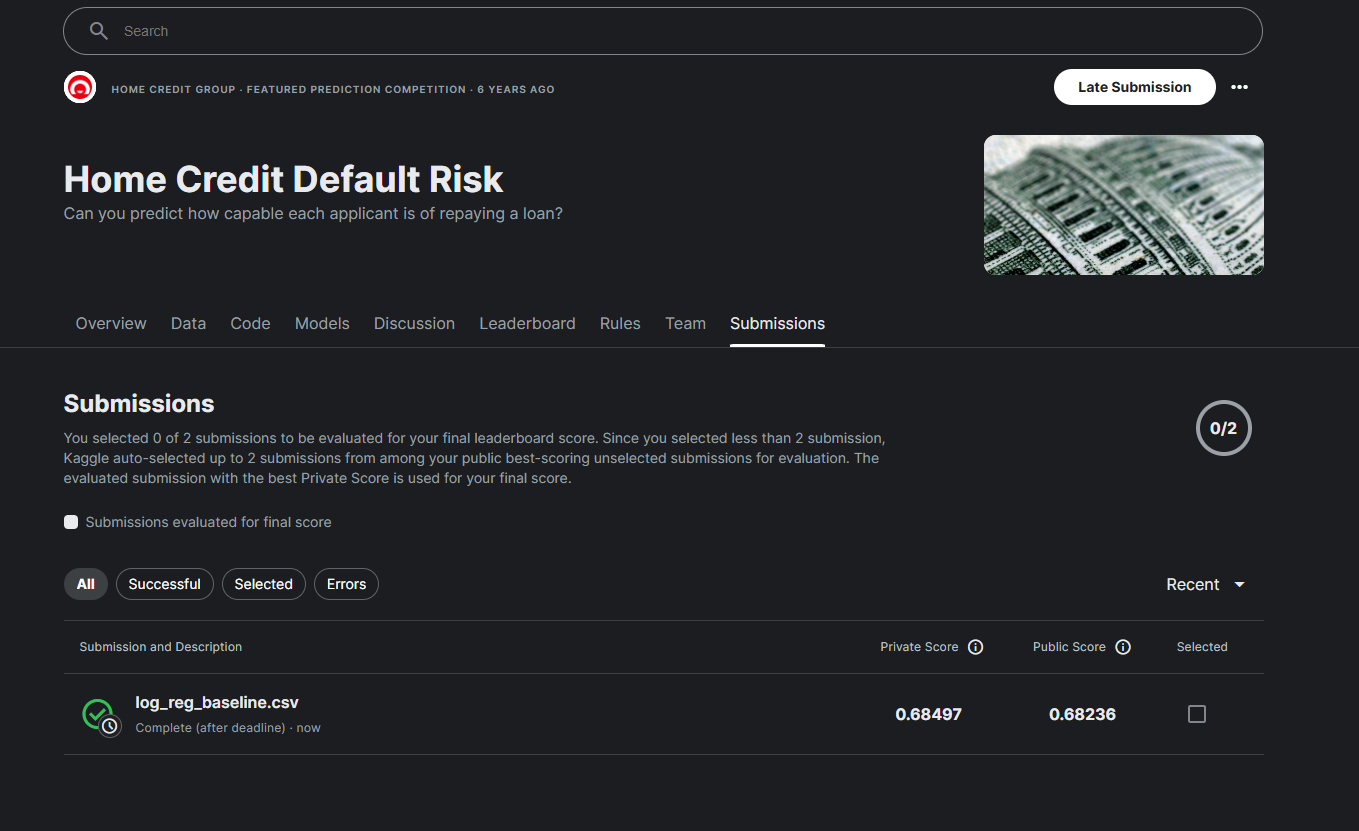

In [16]:
from IPython import display
display.Image("result.png")